In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import norm, t, sem, percentileofscore

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import (
    IntegerComparator,
    WeightedAdder,
    LinearAmplitudeFunction,
)


from qiskit_aer.primitives import Sampler
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem

from qiskit_finance.circuit.library import (
    GaussianConditionalIndependenceModel as GCI,
)

import pennylane as qml

In [6]:
_dpi = 800

## Setup

### Parameters

In [7]:
K = 5
n_z = K

z_max = 2
z_values = np.linspace(-z_max, z_max, 2**K)
z_cdf = norm.cdf(z_values)
p_zeros = [0.15, 0.25, 0.5, 0.11, 0.32]
rhos = [0.1, 0.05, 0.08, 0.23, 0.08]
lgd = [1, 2, 3, 4, 2]
alpha = 0.05

x_eval = int(np.ceil(np.mean(lgd)))

In [8]:
def empirical_cdf(x_values, loss_data):
    cdf_values = [np.mean(loss_data <= x) for x in x_values]
    return cdf_values

### Uncertainty Model

In [9]:
u = GCI(n_z, z_max, p_zeros, rhos)

In [10]:
binary_probabilities_list = []
for i in range(5):
    u_measure = u.measure_all(inplace=False)
    sampler = Sampler()
    job = sampler.run(u_measure)
    binary_probabilities = job.result().quasi_dists[0].binary_probabilities()
    binary_probabilities_list.append(binary_probabilities)

### Empirical Calculations

In [11]:
market_data = []

for j in range(5):
    market_fixed_data = {}
    p_z = np.zeros(2**n_z)
    p_default = np.zeros(K)
    values = []
    probabilities = []
    num_qubits = u.num_qubits
    binary_probabilities = binary_probabilities_list[j]

    for i, prob in binary_probabilities.items():
        # extract value of Z and corresponding probability
        i_normal = int(i[-n_z:], 2)
        p_z[i_normal] += prob

        # determine overall default probability for k
        loss = 0
        for k in range(K):
            if i[K - k - 1] == "1":
                p_default[k] += prob
                loss += lgd[k]

        values += [loss]
        probabilities += [prob]

    values = np.array(values)
    probabilities = np.array(probabilities)

    exact_expected_loss = np.dot(values, probabilities)
    losses = np.sort(np.unique(values))
    pdf = np.zeros(len(losses))
    for i, v in enumerate(losses):
        pdf[i] += sum(probabilities[values == v])
    cdf = np.cumsum(pdf)

    i_var = np.argmax(cdf >= 1 - alpha)
    exact_var = losses[i_var]
    exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(
        pdf[(i_var + 1) :]
    )

    # Market Data
    market_fixed_data["p_z"] = p_z
    market_fixed_data["pdf"] = pdf
    market_fixed_data["losses"] = losses
    market_fixed_data["run_num"] = j
    market_fixed_data["seed"] = np.random.randint(50, 100)
    market_fixed_data["cdf"] = cdf
    market_fixed_data["x_values"] = np.linspace(0, sum(lgd), 2**K)

    # Empirical Calculations Answers
    market_fixed_data["Empirical Calculations"] = {
        "expected_loss": exact_expected_loss,
        "var": exact_var,
        "cvar": exact_cvar,
        "probability": cdf[exact_var],
        "cdf": cdf,
        "cdf_5": cdf[x_eval],
        "confidence_interval": [
            percentileofscore(losses, x) / 100
            for x in t.interval(
                confidence=1 - alpha, df=len(losses) - 1, loc=x_eval, scale=sem(losses)
            )
        ],
        "losses": losses,
    }

    market_data.append(market_fixed_data)

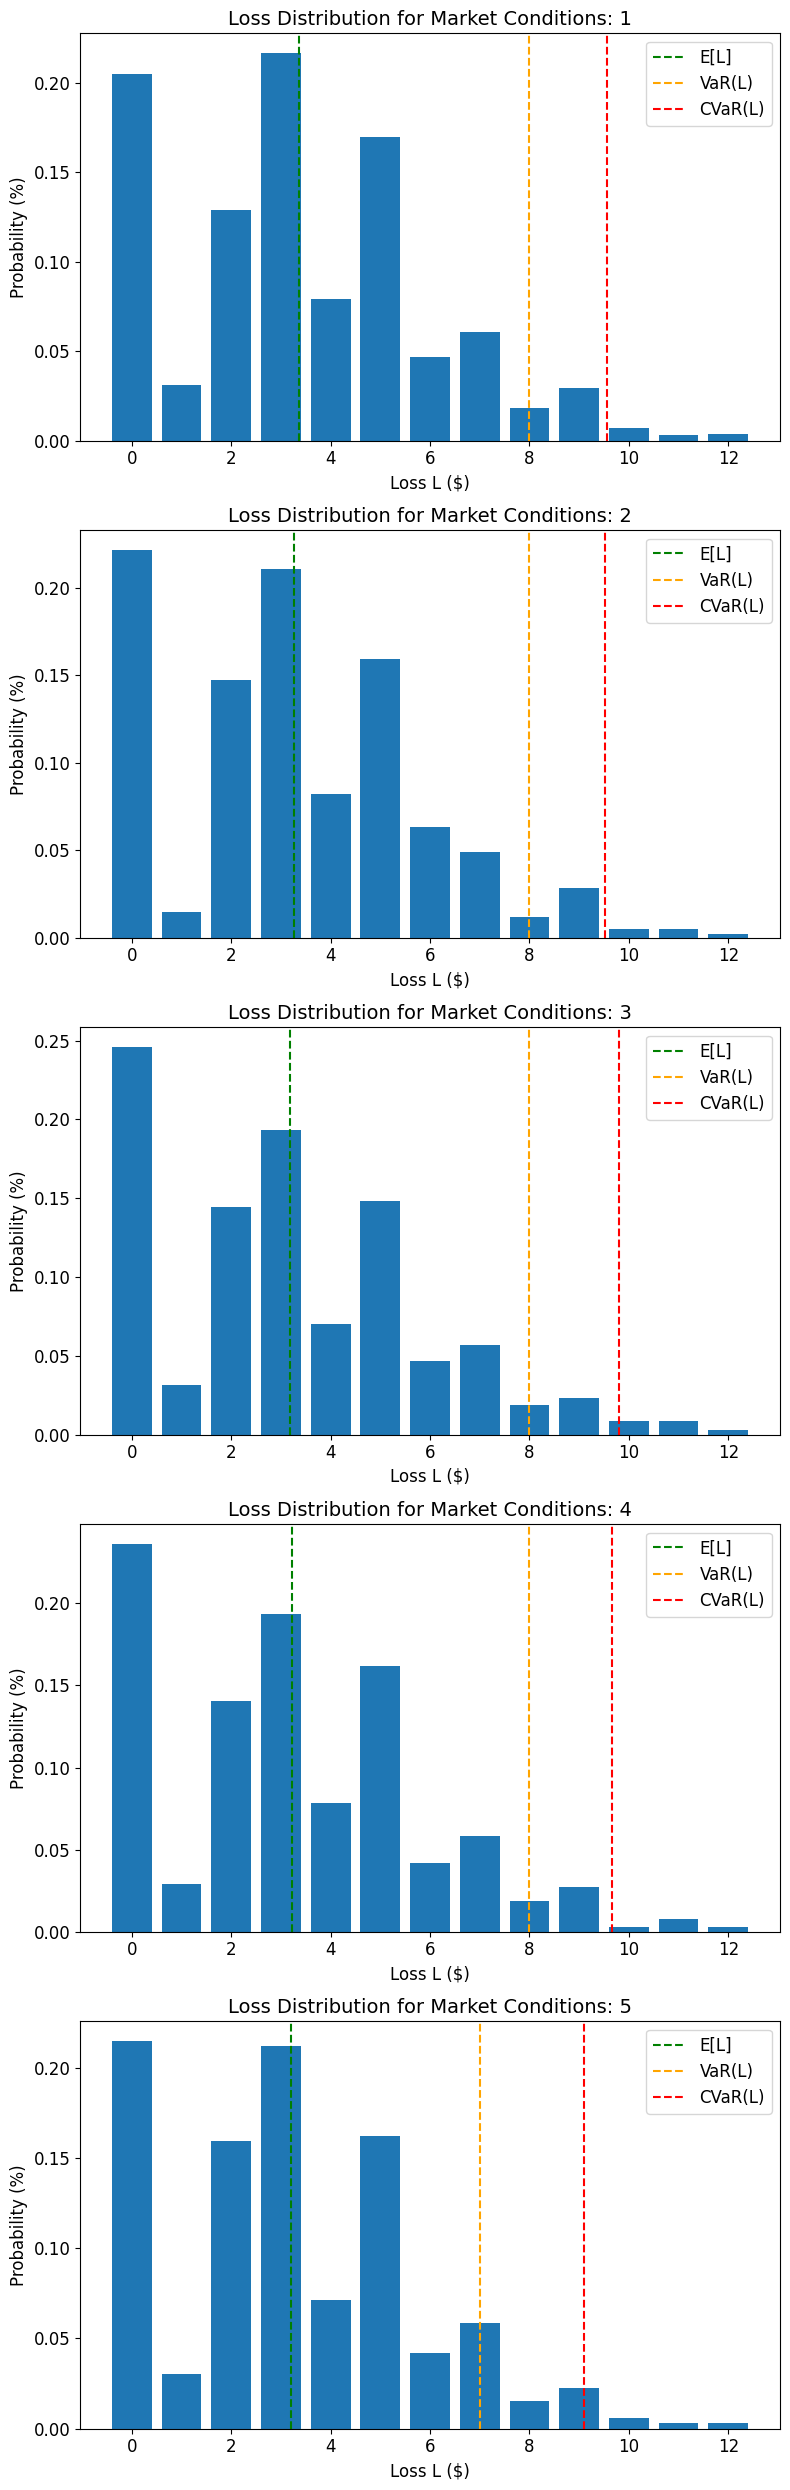

In [12]:
fig, axes = plt.subplots(len(market_data), 1, figsize=(8, 5 * len(market_data)))

if len(market_data) == 1:
    axes = [axes]  # Ensure axes is always iterable

for i, (ax, market_data_run) in enumerate(zip(axes, market_data)):
    losses = market_data_run.get("losses")
    pdf = market_data_run.get("pdf")
    empirical_calc = market_data_run.get("Empirical Calculations", {})

    expected_loss = empirical_calc.get("expected_loss")
    var = empirical_calc.get("var")
    cvar = empirical_calc.get("cvar")

    ax.bar(losses, pdf)
    ax.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
    ax.axvline(var, color="orange", linestyle="--", label="VaR(L)")
    ax.axvline(cvar, color="red", linestyle="--", label="CVaR(L)")
    ax.legend(fontsize=12)
    ax.set_xlabel("Loss L ($)", size=12)
    ax.set_ylabel("Probability (%)", size=12)
    ax.set_title(f"Loss Distribution for Market Conditions: {i+1}", size=14)
    ax.tick_params(axis="both", labelsize=12)

plt.tight_layout()
plt.show()

### Market Conditions

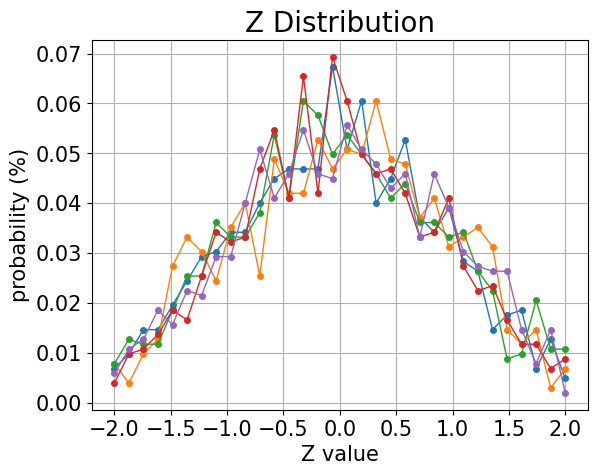

In [ ]:
plt.plot(z_values, market_data[0].get("p_z"), "o-", linewidth=1, markersize=4)
plt.plot(z_values, market_data[1].get("p_z"), "o-", linewidth=1, markersize=4)
plt.plot(z_values, market_data[2].get("p_z"), "o-", linewidth=1, markersize=4)
plt.plot(z_values, market_data[3].get("p_z"), "o-", linewidth=1, markersize=4)
plt.plot(z_values, market_data[4].get("p_z"), "o-", linewidth=1, markersize=4)
plt.grid()
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel("Z value", size=18)
plt.ylabel("probability (%)", size=18)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

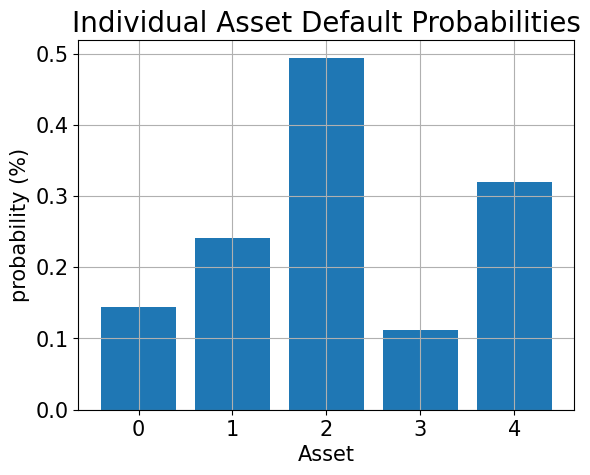

In [14]:
plt.bar(range(K), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Individual Asset Default Probabilities", size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

## Classical Simulation

In [15]:
rhos_np = np.array(rhos)
lgd_np = np.array(lgd)
probit_thresholds = norm.ppf(p_zeros)
number_simulations = 10000000

In [16]:
def simulate_portfolio_losses_classic(p_z):
    losses = np.zeros(number_simulations)

    for i in range(number_simulations):
        z = np.random.choice(z_values, p=p_z)
        Y = np.random.normal(0, 1, K)
        credit_events = (np.sqrt(rhos_np) * z) + (np.sqrt(1 - rhos_np) * Y)
        defaults = credit_events < probit_thresholds
        losses[i] = np.sum(defaults * lgd_np)

    return losses


def calculate_var_cvar(losses, alpha=0.05):

    e_loss = np.mean(losses)
    var = np.percentile(losses, (1 - alpha) * 100)
    cvar = np.mean(losses[losses >= var])
    return e_loss, var, cvar


def compute_stats(lst):
    q1 = np.percentile(lst, 25)
    q3 = np.percentile(lst, 75)
    iqr = q3 - q1
    return iqr

In [17]:
for i, market_data_run in enumerate(market_data):
    classical_losses = simulate_portfolio_losses_classic(market_data_run.get("p_z"))
    classical_expected_losses, classical_var, classical_cvar = calculate_var_cvar(
        losses=classical_losses
    )
    cmc_cdf = empirical_cdf(market_data_run.get("x_values"), classical_losses)

    market_data[i]["Classical Monte Carlo"] = {
        "expected_loss": classical_expected_losses,
        "var": classical_var,
        "cvar": classical_cvar,
        "probability": market_data_run.get("cdf")[int(classical_var)],
        "cdf": cmc_cdf,
        "cdf_5": cmc_cdf[x_eval],
        "confidence_interval": [
            percentileofscore(classical_losses, x) / 100
            for x in t.interval(
                confidence=1 - alpha,
                df=len(classical_losses) - 1,
                loc=x_eval,
                scale=sem(classical_losses),
            )
        ],
        "losses": classical_losses,
    }

In [18]:
for i, run_data in enumerate(market_data):
    print(
        "Expected Loss E[L]:       %.4f"
        % run_data.get("Empirical Calculations", {}).get("expected_loss")
    )
    print(
        "Expected Loss E[L] CMC:   %.4f"
        % run_data.get("Classical Monte Carlo", {}).get("expected_loss")
    )
    print("#" * 25)

    print(
        "Exact Value at Risk:     %2d"
        % run_data.get("Empirical Calculations", {}).get("var")
    )
    print(
        "CMC Value at Risk:       %2d"
        % run_data.get("Classical Monte Carlo", {}).get("var")
    )

    print("#" * 25)

    print(
        "Exact CVaR:    \t%.4f" % run_data.get("Empirical Calculations", {}).get("cvar")
    )
    print(
        "CMC CVaR:      \t%.4f" % run_data.get("Classical Monte Carlo", {}).get("cvar")
    )
    print(
        f"Exact Confidence Interval: {run_data.get('Empirical Calculations', {}).get('confidence_interval')}"
    )
    print(
        f"CMC Confidence Interval: {run_data.get('Classical Monte Carlo', {}).get('confidence_interval')}"
    )
    print("*" * 50)

Expected Loss E[L]:       3.3701
Expected Loss E[L] CMC:   3.2292
#########################
Exact Value at Risk:      8
CMC Value at Risk:        8
#########################
Exact CVaR:    	9.5682
CMC CVaR:      	9.1401
Exact Confidence Interval: [0.07692307692307693, 0.4615384615384615]
CMC Confidence Interval: [0.3948816, 0.6090641000000001]
**************************************************
Expected Loss E[L]:       3.2637
Expected Loss E[L] CMC:   3.1929
#########################
Exact Value at Risk:      8
CMC Value at Risk:        8
#########################
Exact CVaR:    	9.5122
CMC CVaR:      	9.1362
Exact Confidence Interval: [0.07692307692307693, 0.4615384615384615]
CMC Confidence Interval: [0.40048820000000007, 0.6152272000000001]
**************************************************
Expected Loss E[L]:       3.1807
Expected Loss E[L] CMC:   3.2247
#########################
Exact Value at Risk:      8
CMC Value at Risk:        8
#########################
Exact CVaR:    	9.8000

# Quantum Amplitude Estimation

### Expected Loss

In [19]:
agg = WeightedAdder(n_z + K, [0] * n_z + lgd)

In [20]:
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [21]:
# define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
qr_control = QuantumRegister(1, "control")

# define the circuit
state_preparation = QuantumCircuit(
    qr_state, qr_obj, qr_sum, qr_carry, qr_control, name="A"
)

# load the random variable
state_preparation.append(u.to_gate(), qr_state)

# aggregate
state_preparation.append(
    agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:]
)

# # linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# # uncompute aggregation
state_preparation.append(
    agg.to_gate().inverse(),
    qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:],
)

In [22]:
state_preparation.draw("mpl", style="clifford").savefig(
    f"../circuits/ae_el.png", dpi=_dpi, bbox_inches="tight"
)

In [23]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

#### Validation 

In [24]:
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        value += prob

print(
    "Exact Expected Loss:   %.4f"
    % market_data[0].get("Empirical Calculations", {}).get("expected_loss")
)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Expected Loss:   3.3701
Exact Operator Value:  0.3848
Mapped Operator value: 2.4787


#### Quantum Amplitude Estimation

In [25]:
epsilon = 0.001
alpha = 0.05

for i, market_data_run in enumerate(market_data):
    problem = EstimationProblem(
        state_preparation=state_preparation,
        objective_qubits=[len(qr_state)],
        post_processing=objective.post_processing,
    )
    # construct amplitude estimation
    ae = IterativeAmplitudeEstimation(
        epsilon_target=epsilon,
        alpha=alpha,
        sampler=Sampler(
            run_options={"shots": 1000, "seed": market_data_run.get("seed")}
        ),
    )
    result = ae.estimate(problem)

    # print results
    conf_int = np.array(result.confidence_interval_processed)
    qc_expected_loss = result.estimation_processed

    market_data[i]["Quantum Amplitude Estimation"] = {
        "expected_loss": qc_expected_loss,
        "var": None,
        "cvar": None,
        "probability": None,
        "cdf": None,
        "cdf_5": None,
        "confidence_interval": None,
    }

#### Cumulative Distribution Function

In [26]:
comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)

In [27]:
def get_cdf_circuit(x_eval):
    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, "state")
    qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
    qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
    qr_obj = QuantumRegister(1, "objective")
    qr_compare = QuantumRegister(1, "compare")
    qr_control = QuantumRegister(1, "control")

    # define the circuit
    state_preparation = QuantumCircuit(
        qr_state, qr_obj, qr_sum, qr_carry, qr_control, name="A"
    )

    # load the random variable
    state_preparation.append(u, qr_state)

    # aggregate
    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

    # comparator objective function
    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:])

    # uncompute aggregation
    state_preparation.append(
        agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:]
    )

    return state_preparation

In [28]:
state_preparation = get_cdf_circuit(x_eval)

In [29]:
state_preparation.draw("mpl", style="clifford").savefig(
    f"../circuits/ae_cdf.png", dpi=_dpi, bbox_inches="tight"
)

In [30]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [31]:
var_prob = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        var_prob += prob

print("Operator CDF(%s)" % x_eval + " = %.4f" % var_prob)
print("Exact    CDF(%s)" % x_eval + " = %.4f" % cdf[x_eval])

Operator CDF(3) = 0.5967
Exact    CDF(3) = 0.6162


In [32]:
problem = EstimationProblem(
    state_preparation=state_preparation, objective_qubits=[len(qr_state)]
)
for i, market_data_run in enumerate(market_data):
    ae_cdf = IterativeAmplitudeEstimation(
        epsilon_target=epsilon,
        alpha=alpha,
        sampler=Sampler(
            run_options={"shots": 1000, "seed": market_data_run.get("seed")}
        ),
    )
    result_cdf = ae_cdf.estimate(problem)

    # print results
    conf_int = np.array(result_cdf.confidence_interval)
    market_data[i]["Quantum Amplitude Estimation"]["cdf_5"] = result_cdf.estimation
    market_data[i]["Quantum Amplitude Estimation"]["confidence_interval"] = conf_int

### Value At Risk

In [33]:
def run_iae_for_cdf(x_eval, seed, epsilon=0.01, alpha=0.05):

    # construct amplitude estimation
    state_preparation = get_cdf_circuit(x_eval)
    problem = EstimationProblem(
        state_preparation=state_preparation, objective_qubits=[len(qr_state)]
    )
    ae_var = IterativeAmplitudeEstimation(
        epsilon_target=epsilon,
        alpha=alpha,
        sampler=Sampler(run_options={"shots": 1000, "seed": seed}),
    )
    result_var = ae_var.estimate(problem)
    ae_var.construct_circuit(problem, k=5).draw("mpl", style="clifford").savefig(
        f"../circuits/ae_var.png", dpi=_dpi, bbox_inches="tight"
    )

    return result_var.estimation

In [34]:
def bisection_search(
    objective,
    target_value,
    low_level,
    high_level,
    low_value=None,
    high_value=None,
):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1

    if low_value > target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif low_value == target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    if high_value < target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif high_value == target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    return {
        "level": high_level,
        "value": high_value,
        "num_eval": num_eval,
        "comment": "success",
    }

In [35]:
for i, market_data_run in enumerate(market_data):
    objective = lambda x: run_iae_for_cdf(x, market_data_run.get("seed"))
    bisection_result = bisection_search(
        objective,
        1 - alpha,
        min(market_data_run.get("losses")) - 1,
        max(market_data_run.get("losses")),
        low_value=0,
        high_value=1,
    )
    qc_var = bisection_result["level"]
    market_data[i]["Quantum Amplitude Estimation"]["var"] = qc_var
    market_data[i]["Quantum Amplitude Estimation"]["probability"] = market_data_run.get(
        "cdf"
    )[qc_var]
    market_data[i]["bisection_result"] = bisection_result

### Conditional Value at Risk

In [36]:
for i, market_data_run in enumerate(market_data):
    qc_var = market_data_run.get("Quantum Amplitude Estimation").get("var")
    breakpoints = [0, qc_var]
    slopes = [0, 1]
    offsets = [0, 0]  # subtract VaR and add it later to the estimate
    f_min = 0
    f_max = 8 - qc_var
    c_approx = 0.25

    cvar_objective = LinearAmplitudeFunction(
        agg.num_sum_qubits,
        slopes,
        offsets,
        domain=(0, 2**agg.num_sum_qubits - 1),
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints,
    )

    market_data[i]["cvar_objective"] = cvar_objective

In [37]:
for i, market_data_run in enumerate(market_data):
    cvar_objective = market_data_run.get("cvar_objective")
    qr_state = QuantumRegister(u.num_qubits, "state")
    qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
    qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
    qr_obj = QuantumRegister(1, "objective")
    qr_work = QuantumRegister(cvar_objective.num_ancillas - len(qr_carry), "work")
    qr_control = QuantumRegister(1, "control")

    # define the circuit
    state_preparation = QuantumCircuit(
        qr_state, qr_obj, qr_sum, qr_carry, qr_work, qr_control, name="A"
    )

    # load the random variable
    state_preparation.append(u, qr_state)

    # aggregate
    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

    # linear objective function
    state_preparation.append(
        cvar_objective, qr_sum[:] + qr_obj[:] + qr_carry[:] + qr_work[:]
    )

    # uncompute aggregation
    state_preparation.append(
        agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:]
    )

    market_data[i]["state_preparation"] = state_preparation

In [38]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

#### Validation

In [39]:
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1)] == "1":
        value += prob

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = 1.0 - market_data[0].get("bisection_result")["value"]
v = value / d if d != 0 else 0
normalized_value = v + market_data[0].get("Quantum Amplitude Estimation").get("var")

print("Exact CVaR:     %.4f" % market_data[0].get("Empirical Calculations").get("cvar"))
print("Estimated CVaR: %.4f" % normalized_value)

Exact CVaR:     9.5682
Estimated CVaR: 8.6301


#### Quantum Simulation

In [40]:
for i, market_data_run in enumerate(market_data):
    problem = EstimationProblem(
        state_preparation=market_data_run.get("state_preparation"),
        objective_qubits=[len(qr_state)],
        post_processing=market_data_run.get("cvar_objective").post_processing,
    )
    ae_cvar = IterativeAmplitudeEstimation(
        epsilon_target=epsilon,
        alpha=alpha,
        sampler=Sampler(
            run_options={"shots": 1000, "seed": market_data_run.get("seed")}
        ),
    )
    result_cvar = ae_cvar.estimate(problem)
    ae_cvar.construct_circuit(problem, k=5).draw("mpl", style="clifford").savefig(
        f"../circuits/ae_cvar.png", dpi=_dpi, bbox_inches="tight"
    )

    d = 1.0 - market_data_run.get("bisection_result")["value"]
    v = result_cvar.estimation_processed / d if d != 0 else 0
    qc_cvar = v + market_data_run.get("Quantum Amplitude Estimation").get("var")
    market_data[i]["Quantum Amplitude Estimation"]["cvar"] = qc_cvar

### PennyLane Quantun Monte Carlo - Phase Estimation

In [41]:
M = 2**K
n = 10
N = 2**n


def func(z):
    Y = np.random.normal(0, 1, 1)  # Asset specific factor
    credit_events = (np.sqrt(rhos[i]) * z_values[z]) + (np.sqrt(1 - rhos[i]) * Y)

    return credit_events < probit_thresholds[i]


for j, market_data_run in enumerate(market_data):
    pl_losses = []

    for _ in range(20):
        e_L = []
        for i in range(K):
            target_wires = range(K + 1)
            estimation_wires = range(K + 1, n + K + 1)
            dev = qml.device("default.qubit", wires=(n + K + 1))

            @qml.qnode(dev)
            def circuit():
                qml.templates.QuantumMonteCarlo(
                    market_data_run.get("p_z"),
                    func,
                    target_wires=target_wires,
                    estimation_wires=estimation_wires,
                )
                return qml.probs(estimation_wires)

            phase_estimated = np.argmax(circuit()[: int(N / 2)]) / N

            e_L.append(((1 - np.cos(np.pi * phase_estimated)) / 2) * lgd[i])
        pl_losses.append(sum(e_L))

    e_loss, var, cvar = calculate_var_cvar(np.array(pl_losses))

    cmc_cdf = empirical_cdf(market_data_run.get("x_values"), pl_losses)
    market_data[j]["Quantum Monte Carlo by PennyLane"] = {
        "expected_loss": e_loss,
        "var": var,
        "cvar": cvar,
        "probability": market_data_run.get("cdf")[int(var)],
        "cdf": cmc_cdf,
        "cdf_5": cmc_cdf[x_eval],
        "confidence_interval": [
            percentileofscore(pl_losses, x) / 100
            for x in t.interval(
                confidence=1 - alpha,
                df=len(pl_losses) - 1,
                loc=x_eval,
                scale=sem(pl_losses),
            )
        ],
        "losses": pl_losses,
    }

## Results Comparison

In [42]:
def abs_error(m1, m2):
    return abs(m1 - m2)


def relative_error(m1, m2):
    return abs_error(m1, m2) / abs(m1)


def mse(m1, m2):
    return (m2 - m1) ** 2

In [43]:
table_data = []
for market_data_run in market_data:
    run_number = market_data_run.get("run_num")
    exact_expected_loss = market_data_run.get("Empirical Calculations").get(
        "expected_loss"
    )
    exact_var = market_data_run.get("Empirical Calculations").get("var")
    exact_cvar = market_data_run.get("Empirical Calculations").get("cvar")
    exact_probablity = market_data_run.get("Empirical Calculations").get("probability")

    calc_list = [
        "Empirical Calculations",
        "Classical Monte Carlo",
        "Quantum Amplitude Estimation",
        "Quantum Monte Carlo by PennyLane",
    ]
    for calculation in calc_list:
        data = market_data_run.get(calculation)
        table_data.append(
            {
                "Name": calculation,
                "Market Conditions": run_number,
                "Expected Loss": data.get("expected_loss"),
                "VaR": data.get("var"),
                "CVaR": data.get("cvar"),
                "Probability": data.get("probability"),
                "CDF(5)": data.get("cdf_5"),
                "Confidence Interval": [
                    round(x, 4) for x in data.get("confidence_interval")
                ],
                "EL": data.get("expected_loss"),
                "EL AE": abs_error(
                    exact_expected_loss, data.get("expected_loss")
                ),
                "EL RE": relative_error(
                    exact_expected_loss, data.get("expected_loss")
                ),
                "EL MSE": mse(exact_expected_loss, data.get("expected_loss")),
                "VaR": data.get("var"),
                "VAR AE": abs_error(exact_var, data.get("var")),
                "VAR RE": relative_error(exact_var, data.get("var")),
                "VAR MSE": mse(exact_var, data.get("var")),
                "CVaR": data.get("cvar"),
                "CVAR AE": abs_error(exact_cvar, data.get("cvar")),
                "CVAR RE": relative_error(exact_cvar, data.get("cvar")),
                "CVAR MSE": mse(exact_cvar, data.get("cvar")),
            }
        )


df_table = (
    pd.DataFrame(table_data)
    .sort_values(["Name", "Market Conditions"])
    .replace(
        {
            "Classical Monte Carlo": "CMC",
            "Empirical Calculations": "EC",
            "Quantum Amplitude Estimation": "QAE",
            "Quantum Monte Carlo by PennyLane": "QMC",
        }
    )
)

df_table_values = df_table[["Name", "Expected Loss", "VaR", "CVaR", "Probability"]]
df_table_values_el = df_table[["Name", "Expected Loss", "EL AE", "EL RE", "EL MSE"]]
df_table_values_var = df_table[["Name", "VaR", "VAR AE", "VAR RE", "VAR MSE"]]
df_table_values_cvar = df_table[["Name", "CVaR", "CVAR AE", "CVAR RE", "CVAR MSE"]]


In [ ]:
for i, market_data_run in enumerate(market_data):
    plt.figure(figsize=(8, 5))
    data_box = {
        "CMC": market_data_run.get("Classical Monte Carlo").get("losses"),
        "QMC": market_data_run.get("Quantum Monte Carlo by PennyLane").get("losses"),
        
    }

    plt.figure(figsize=(8, 5))
    sns.boxplot(
        data=data_box,
        orient="h",
        width=0.5,
        
        palette="pastel",
    )
    
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.title("Expected Loss Distribution for Monte Carlo Simulations", fontsize=20)
    plt.xlabel("Expected Loss Value Distributions", fontsize=18)

    plt.savefig(
        f"../graphs/box_for_market{i}.png", dpi=_dpi, bbox_inches="tight"
    )

Initial Averages Table

In [ ]:
print(
    df_table_values.groupby("Name")
    .mean()
    .reset_index()
    .to_latex(index=False, float_format="%.4f")
)


print(
    df_table_values_el.groupby("Name")
    .mean()
    .reset_index()
    .to_latex(index=False, float_format="%.4f")
)

print(
    df_table_values_var.groupby("Name")
    .mean()
    .reset_index()
    .to_latex(index=False, float_format="%.4f")
)


print(
    df_table_values_cvar.groupby("Name")
    .mean()
    .reset_index()
    .to_latex(index=False, float_format="%.4f")
)

\begin{tabular}{lrrrr}
\toprule
Name & Expected Loss & VaR & CVaR & Probability \\
\midrule
CMC & 3.1911 & 7.6000 & 8.6900 & 0.9604 \\
EC & 3.1375 & 7.4000 & 9.3049 & 0.9586 \\
QAE & 3.2040 & 7.0000 & 8.5796 & 0.9510 \\
QMC & 2.9250 & 3.5430 & 3.7177 & 0.6271 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
Name & Expected Loss & EL AE & EL RE & EL MSE \\
\midrule
CMC & 3.1911 & 0.0536 & 0.0172 & 0.0040 \\
EC & 3.1375 & 0.0000 & 0.0000 & 0.0000 \\
QAE & 3.2040 & 0.0923 & 0.0295 & 0.0091 \\
QMC & 2.9250 & 0.2125 & 0.0675 & 0.0478 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
Name & VaR & VAR AE & VAR RE & VAR MSE \\
\midrule
CMC & 7.6000 & 0.2000 & 0.0286 & 0.2000 \\
EC & 7.4000 & 0.0000 & 0.0000 & 0.0000 \\
QAE & 7.0000 & 0.4000 & 0.0500 & 0.4000 \\
QMC & 3.5430 & 3.8570 & 0.5190 & 15.1614 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
Name & CVaR & CVAR AE & CVAR RE & CVAR MSE \\
\midrule
CMC & 8.6900 & 0.6149 & 0.0667 & 0.5108 \\
EC & 9.304

In [47]:
df_table_values = df_table[["Name", "Market Conditions","Expected Loss", "VaR", "CVaR", "Probability"]]
df_table_values_el = df_table[["Name", "Market Conditions","Expected Loss", "EL AE", "EL RE", "EL MSE"]]
df_table_values_var = df_table[["Name", "Market Conditions","VaR", "VAR AE", "VAR RE", "VAR MSE"]]
df_table_values_cvar = df_table[["Name", "Market Conditions","CVaR", "CVAR AE", "CVAR RE", "CVAR MSE"]]


print(
    df_table_values.to_latex(index=False, float_format="%.4f")
)
print(
    df_table_values_el.to_latex(index=False, float_format="%.4f")
)
print(
    df_table_values_var.to_latex(index=False, float_format="%.4f")
)
print(
    df_table_values_cvar.to_latex(index=False, float_format="%.4f")
)



\begin{tabular}{lrrrrr}
\toprule
Name & Market Conditions & Expected Loss & VaR & CVaR & Probability \\
\midrule
CMC & 0 & 3.2292 & 8.0000 & 9.1401 & 0.9570 \\
CMC & 1 & 3.1929 & 8.0000 & 9.1362 & 0.9600 \\
CMC & 2 & 3.2247 & 8.0000 & 9.1390 & 0.9561 \\
CMC & 3 & 3.2104 & 8.0000 & 9.1272 & 0.9590 \\
CMC & 4 & 3.1879 & 8.0000 & 9.1357 & 0.9658 \\
EC & 0 & 3.3701 & 8.0000 & 9.5682 & 0.9570 \\
EC & 1 & 3.2637 & 8.0000 & 9.5122 & 0.9600 \\
EC & 2 & 3.1807 & 8.0000 & 9.8000 & 0.9561 \\
EC & 3 & 3.2207 & 8.0000 & 9.6667 & 0.9590 \\
EC & 4 & 3.1953 & 7.0000 & 9.0980 & 0.9502 \\
QAE & 0 & 3.2001 & 7.0000 & 8.6010 & 0.9385 \\
QAE & 1 & 3.1992 & 7.0000 & 8.5855 & 0.9482 \\
QAE & 2 & 3.2118 & 7.0000 & 8.5845 & 0.9375 \\
QAE & 3 & 3.2022 & 7.0000 & 8.5850 & 0.9404 \\
QAE & 4 & 3.2074 & 7.0000 & 8.5665 & 0.9502 \\
QMC & 0 & 2.8353 & 3.4506 & 3.5535 & 0.5820 \\
QMC & 1 & 2.9622 & 3.5455 & 3.9429 & 0.5947 \\
QMC & 2 & 3.0613 & 3.6836 & 4.0961 & 0.6152 \\
QMC & 3 & 2.9790 & 3.3694 & 3.4984 & 0.5996 \\

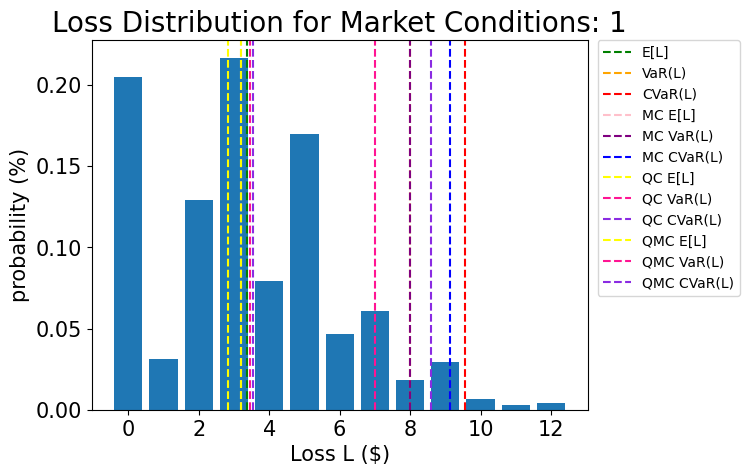

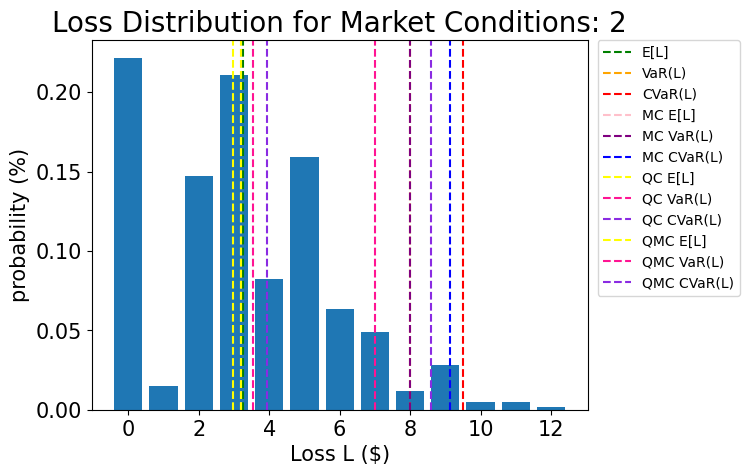

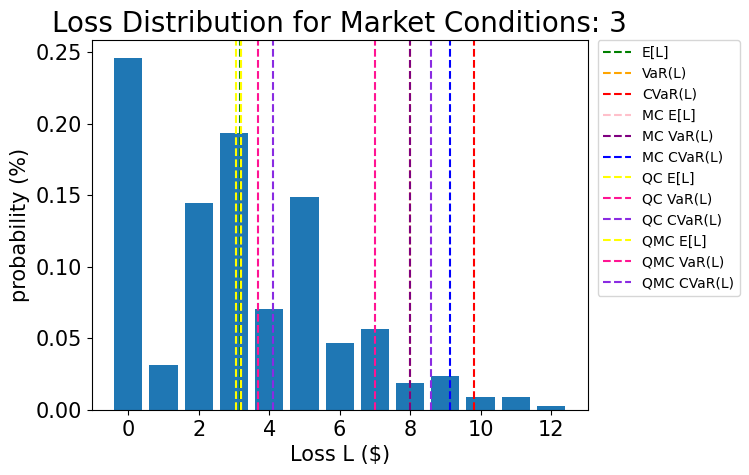

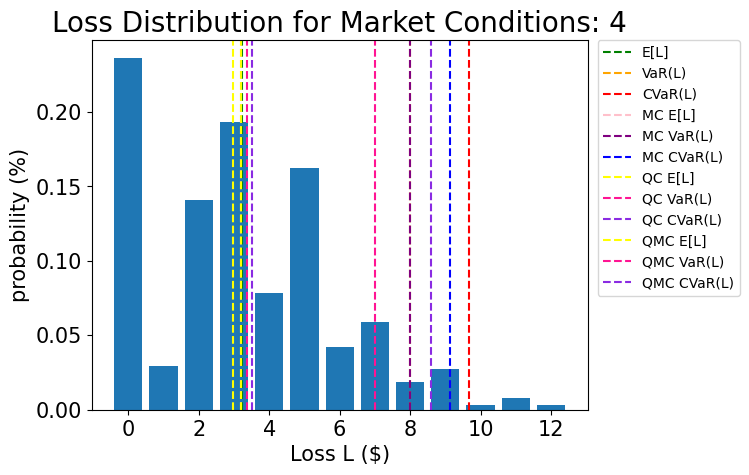

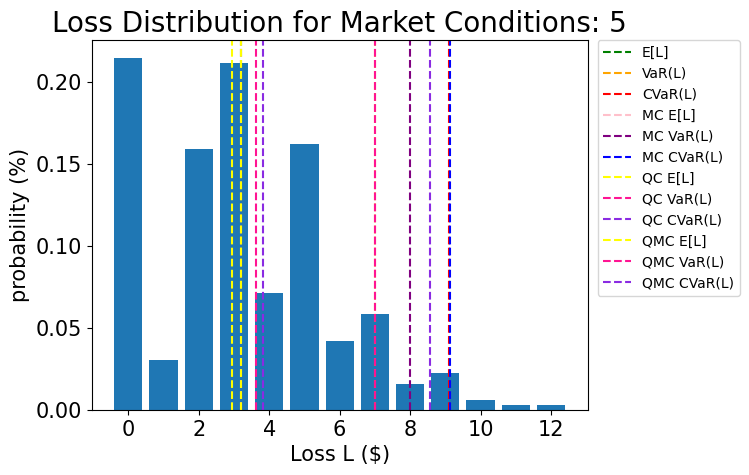

<Figure size 640x480 with 0 Axes>

In [44]:
for i, market_data_run in enumerate(market_data):
    losses = market_data_run.get("losses")
    pdf = market_data_run.get("pdf")

    exact_expected_loss = market_data_run.get("Empirical Calculations").get("expected_loss")
    exact_var = market_data_run.get("Empirical Calculations").get("var")
    exact_cvar = market_data_run.get("Empirical Calculations").get("cvar")

    classical_expected_loss = market_data_run.get("Classical Monte Carlo").get("expected_loss")
    classical_var = market_data_run.get("Classical Monte Carlo").get("var")
    classical_cvar = market_data_run.get("Classical Monte Carlo").get("cvar")

    qc_expected_loss = market_data_run.get("Quantum Amplitude Estimation").get("expected_loss")
    qc_var = market_data_run.get("Quantum Amplitude Estimation").get("var")
    qc_cvar = market_data_run.get("Quantum Amplitude Estimation").get("cvar")

    qmc_expected_loss = market_data_run.get("Quantum Monte Carlo by PennyLane").get("expected_loss")
    qmc_var = market_data_run.get("Quantum Monte Carlo by PennyLane").get("var")
    qmc_cvar = market_data_run.get("Quantum Monte Carlo by PennyLane").get("cvar")

    plt.bar(losses, pdf)

    plt.axvline(exact_expected_loss, color="green", linestyle="--", label="E[L]")
    plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
    plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")

    plt.axvline(classical_expected_losses, color="pink", linestyle="--", label="MC E[L]")
    plt.axvline(classical_var, color="purple", linestyle="--", label="MC VaR(L)")
    plt.axvline(classical_cvar, color="blue", linestyle="--", label="MC CVaR(L)")

    plt.axvline(qc_expected_loss, color="yellow", linestyle="--", label="QC E[L]")
    plt.axvline(qc_var, color="deeppink", linestyle="--", label="QC VaR(L)")
    plt.axvline(qc_cvar, color="blueviolet", linestyle="--", label="QC CVaR(L)")

    plt.axvline(qmc_expected_loss, color="yellow", linestyle="--", label="QMC E[L]")
    plt.axvline(qmc_var, color="deeppink", linestyle="--", label="QMC VaR(L)")
    plt.axvline(qmc_cvar, color="blueviolet", linestyle="--", label="QMC CVaR(L)")

    plt.legend(fontsize=15)
    plt.xlabel("Loss L ($)", size=15)
    plt.ylabel("probability (%)", size=15)
    plt.title(f"Loss Distribution for Market Conditions: {i+1}", size=20)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.show()
    plt.savefig(f"../graphs/loss_diss_{i}.png", dpi=_dpi, bbox_inches="tight")